In [1]:
using Flux
using MLBase: roc, correctrate, precision, recall, f1score, false_positive_rate, false_negative_rate
using MultivariateStats
using PyPlot

push!(LOAD_PATH, pwd(), "/home/jan/dev/anomaly detection/anomaly_detection/src", "/home/jan/dev/FluxExtensions.jl/src")
using KNNmem
using AnomalyDetection

dataPath = "/home/jan/dev/data/loda/public/datasets/numerical"
allData = AnomalyDetection.loaddata(dataPath)


Dict{String,AnomalyDetection.Basicset} with 38 entries:
  "breast-cancer-wisconsin" => AnomalyDetection.Basicset(Float32[13.54 13.08 … …
  "miniboone"               => AnomalyDetection.Basicset(Float32[4.87844 6.4521…
  "haberman"                => AnomalyDetection.Basicset(Float32[30.0 30.0 … 76…
  "blood-transfusion"       => AnomalyDetection.Basicset(Float32[1.0 4.0 … 39.0…
  "ecoli"                   => AnomalyDetection.Basicset(Float32[0.49 0.07 … 0.…
  "madelon"                 => AnomalyDetection.Basicset(Float32[485.0 483.0 … …
  "statlog-satimage"        => AnomalyDetection.Basicset(Float32[92.0 84.0 … 60…
  "parkinsons"              => AnomalyDetection.Basicset(Float32[119.992 122.4 …
  "abalone"                 => AnomalyDetection.Basicset(Float32[0.0 0.0 … 1.0 …
  "iris"                    => AnomalyDetection.Basicset(Float32[5.1 4.9 … 6.2 …
  "yeast"                   => AnomalyDetection.Basicset(Float32[0.58 0.43 … 0.…
  "pendigits"               => AnomalyDetection.Basic

In [2]:
dataset = allData["pendigits"]
train, test, clusterdness = AnomalyDetection.makeset(dataset, 0.8, "normal", 0.05, "high")

(AnomalyDetection.Dataset(Float32[0.038758 -1.12975 … 1.95381 2.1161; 0.257385 -1.70011 … -0.495496 -0.72136; … ; -0.0609262 0.69509 … -0.99943 -0.99943; 2.38367 -0.77989 … -0.77989 -0.77989], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0  …  1, 1, 1, 1, 1, 1, 1, 1, 1, 1]), AnomalyDetection.Dataset(Float32[-0.0586174 0.00629955 … 1.69414 2.1161; 0.85969 -1.02251 … 0.106809 -0.420208; … ; 0.408326 -0.99943 … -0.295552 1.60752; -0.77989 -0.431898 … -0.77989 -0.77989], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0  …  1, 1, 1, 1, 1, 1, 1, 1, 1, 1]), 1.5917835f0)

In [3]:
dataPCA = fit(PCA, train.data; maxoutdim = 3)


PCA(indim = 16, outdim = 3, principalratio = 0.67441)

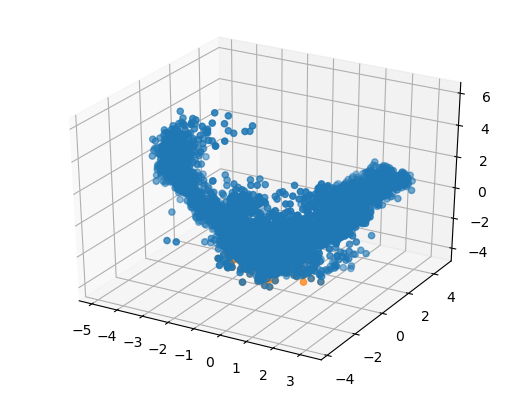

PyObject <mpl_toolkits.mplot3d.art3d.Path3DCollection object at 0x7fabbd3a3cf8>

In [4]:
projectedData = transform(dataPCA, train.data)

backgroundIndeces = train.labels .== 0
anomalyIndeces = train.labels .== 1

scatter3D(projectedData[1,backgroundIndeces], projectedData[2,backgroundIndeces], projectedData[3,backgroundIndeces])
scatter3D(projectedData[1,anomalyIndeces], projectedData[2,anomalyIndeces], projectedData[3,anomalyIndeces])


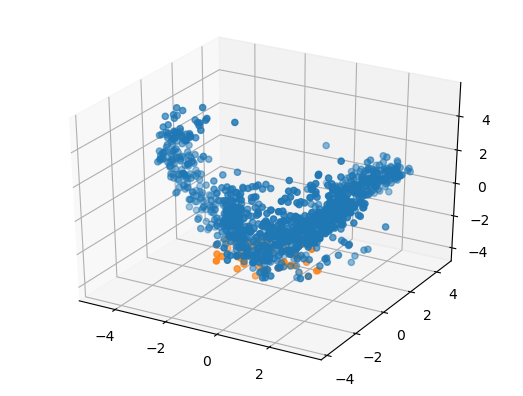

PyObject <mpl_toolkits.mplot3d.art3d.Path3DCollection object at 0x7fabbccf2128>

In [5]:
projectedData = transform(dataPCA, test.data)

backgroundIndeces = test.labels .== 0
anomalyIndeces = test.labels .== 1

scatter3D(projectedData[1,backgroundIndeces], projectedData[2,backgroundIndeces], projectedData[3,backgroundIndeces])
scatter3D(projectedData[1,anomalyIndeces], projectedData[2,anomalyIndeces], projectedData[3,anomalyIndeces])


In [6]:
inputSize = size(train.data, 1)
zSize = 10 # size of the encoding vector
memorySize = 100 # size of the kNN memory
k = 16 # number of the nearest neighbors in the kNN
β = 1. # parameter setting the weight of the memory loss

# RELU could easily create a zero vector which creates problems in the memory
# as the memory demands vectors with a norm = 1 and normalizes the others
encoder = Dense(inputSize, zSize, tanh)
decoder = Dense(zSize, inputSize, tanh)
model = Chain(encoder, decoder)

memory = KNNmemory(memorySize, zSize, k, 2)

reconstructionError(x) = Flux.mse(model(x), x)
loss(x, y) = reconstructionError(x) + β * trainQuery!(memory, encoder(x), y)
opt = ADAM(params(model))

(::#71) (generic function with 1 method)

In [7]:
iterations = 5000
batchSize = 1000

for i in 1:iterations
    # sample from data
    batchIndeces = rand(1:size(train.data, 2),batchSize)
    x = train.data[:, batchIndeces]
    y = train.labels[batchIndeces]

    # gradient computation and update
    l = loss(x, y)
    if i % 100 == 0
        print(l)
        println(" $(reconstructionError(x))")
    end
    Flux.Tracker.back!(l)
    opt()
end

println("Reconstruction err: $(reconstructionError(test.data))")

rocData = roc(test.labels, query(memory, encoder(test.data)))
print(rocData)
print("precision: $(precision(rocData))\n")
print("f1score: $(f1score(rocData))\n")
print("recall: $(recall(rocData))\n")
print("false positive rate: $(false_positive_rate(rocData))\n")
print("equal error rate: $((false_positive_rate(rocData) + false_negative_rate(rocData))/2)\n")

0.719049346818285 (tracked) 0.7044753457828841 (tracked)
0.4605283804461866 (tracked) 0.44661780659512684 (tracked)
0.3756413844794452 (tracked) 0.35874165083202103 (tracked)
0.3211185325816899 (tracked) 0.309049147316451 (tracked)
0.2746875162763225 (tracked) 0.2621838931898547 (tracked)
0.2677589603252579 (tracked) 0.251649713979724 (tracked)
0.24979242450144684 (tracked) 0.23373111438426825 (tracked)
0.23266453211570415 (tracked) 0.21702178947169246 (tracked)
0.22443890731237562 (tracked) 0.21100814119775685 (tracked)
0.2140766284337847 (tracked) 0.2011075466849635 (tracked)
0.22726250280542237 (tracked) 0.21401205864706338 (tracked)
0.21141784126203114 (tracked) 0.19905906236145213 (tracked)
0.20450073603095167 (tracked) 0.1898110291808351 (tracked)
0.201485731781157 (tracked) 0.18814564941102743 (tracked)
0.21275482712865332 (tracked) 0.20043222644554617 (tracked)
0.20426736982812763 (tracked) 0.1896548060357542 (tracked)
0.19717393408362283 (tracked) 0.1835048820358448 (tracked)
